In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import spacy
import nltk
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from sklearn.feature_extraction import stop_words as sklearn_stopwords
from nltk.corpus import stopwords as nltk_stopwords

In [3]:
df = pd.read_csv('/home/cneiderer/Downloads/inaug_speeches_mod.csv')

In [4]:
df.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again calle...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in ea..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALL...
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to th..."


In [5]:
docs = list(df.text)
len(docs)

58

In [6]:
import re

# custom stop words and stop phrases
custom_stopwords = ['mr', 'miss', 'vice president', 'chief justice', 'united states', 'god bless', 
                    'fellow citizens', 'fellow-citizens', 'government']
docs_orig = docs.copy()
for wd in custom_stopwords:
    for idx in range(len(docs)):
        docs[idx] = re.sub(wd, ' ', docs[idx], flags=re.I)
        docs[idx] = re.sub('<[Uu]\+\d{4,4}>', ' ', docs[idx])

In [7]:
sw = set(nltk_stopwords.words('english')).union(sklearn_stopwords.ENGLISH_STOP_WORDS)

In [8]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

for idx, doc in enumerate(docs):
    
    processed_words = []    
    sentences = sent_tokenize(doc)
    for sentence in sentences:
        words = word_tokenize(sentence)
        for word in words:
            processed_words.append(lmtzr.lemmatize(word))
#             processed_words.append(stemmer.stem(word))
#             processed_words.append(lmtzr.lemmatize(stemmer.stem(word)))
                               
    docs[idx] = ' '.join(processed_words)          

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [60]:
n_samples = 2000
n_features = 1000
n_topics = 20
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))
    print()

In [61]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 4), max_df=0.8, min_df=0.02,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(docs)

In [62]:
nmf = NMF(n_components=n_topics, random_state=129, alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
public constitution union states law duty principle peace foreign congress national citizen state party revenue policy opinion war best institution
Topic #1:
america freedom today americans let know work child century american generation day man peace earth history old democracy god dream
Topic #2:
counsel thought thing purpose set action industrial politics process stand current drawn principle immediate private equally influence task opportunity matter
Topic #3:
negro business south tariff race amendment canal congress proper likely law legislation passed issue coast trade prevent feeling court jurisdiction
Topic #4:
war god union let drawn slave seeking said came conflict ago occasion cause party southern come agent devoted divide fundamental
Topic #5:
war honorable received carried battle reliance sympathy suffering spirit issue sense necessary enemy distinguished element placed practice class consideration arm
Topic #6:
program communism democracy peace freedom nations a

In [76]:
components = nmf.components_
component_dicts = []
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20], "\n")
    
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:20]))

topic 0
[('public', 0.22413038606162344), ('constitution', 0.19987345140824428), ('union', 0.19317645254920379), ('states', 0.18045843383003959), ('law', 0.1766509731901012), ('duty', 0.16682472110713753), ('principle', 0.12341317012984583), ('peace', 0.11716341664245374), ('foreign', 0.11329466239837521), ('congress', 0.10856905288968417), ('national', 0.10791115019946797), ('citizen', 0.10560809210207477), ('state', 0.10488820626605476), ('party', 0.10289275066481329), ('revenue', 0.10128416449594281), ('policy', 0.096993159088099523), ('opinion', 0.094957253682611056), ('war', 0.092364244909285492), ('best', 0.092017227781849259), ('institution', 0.088058128976000585)] 

topic 1
[('america', 0.38023942696280666), ('freedom', 0.22827626814758262), ('today', 0.2060769672355876), ('americans', 0.1964818792365304), ('let', 0.15527511165953189), ('know', 0.15037007033991406), ('work', 0.13836415270156424), ('child', 0.1262106702801393), ('century', 0.1238416341045987), ('american', 0.120

In [79]:
component_dicts[11]

{'abiding': 0.0,
 'ability': 0.0,
 'able': 0.0,
 'abroad': 0.0,
 'abuse': 0.0,
 'accept': 0.0,
 'accomplished': 0.0,
 'according': 0.0,
 'achieve': 0.0,
 'achievement': 0.0,
 'act': 0.0,
 'action': 0.0,
 'activity': 0.0,
 'actual': 0.0,
 'adapted': 0.0,
 'add': 0.0,
 'added': 0.0,
 'additional': 0.0,
 'adequate': 0.0,
 'administration': 0.0}

/home/cneiderer/anaconda3/lib/python3.6/site-packages/wordcloud/wordcloud.py:360: RuntimeWarning: invalid value encountered in double_scalars
  for word, freq in frequencies]


ValueError: cannot convert float NaN to integer

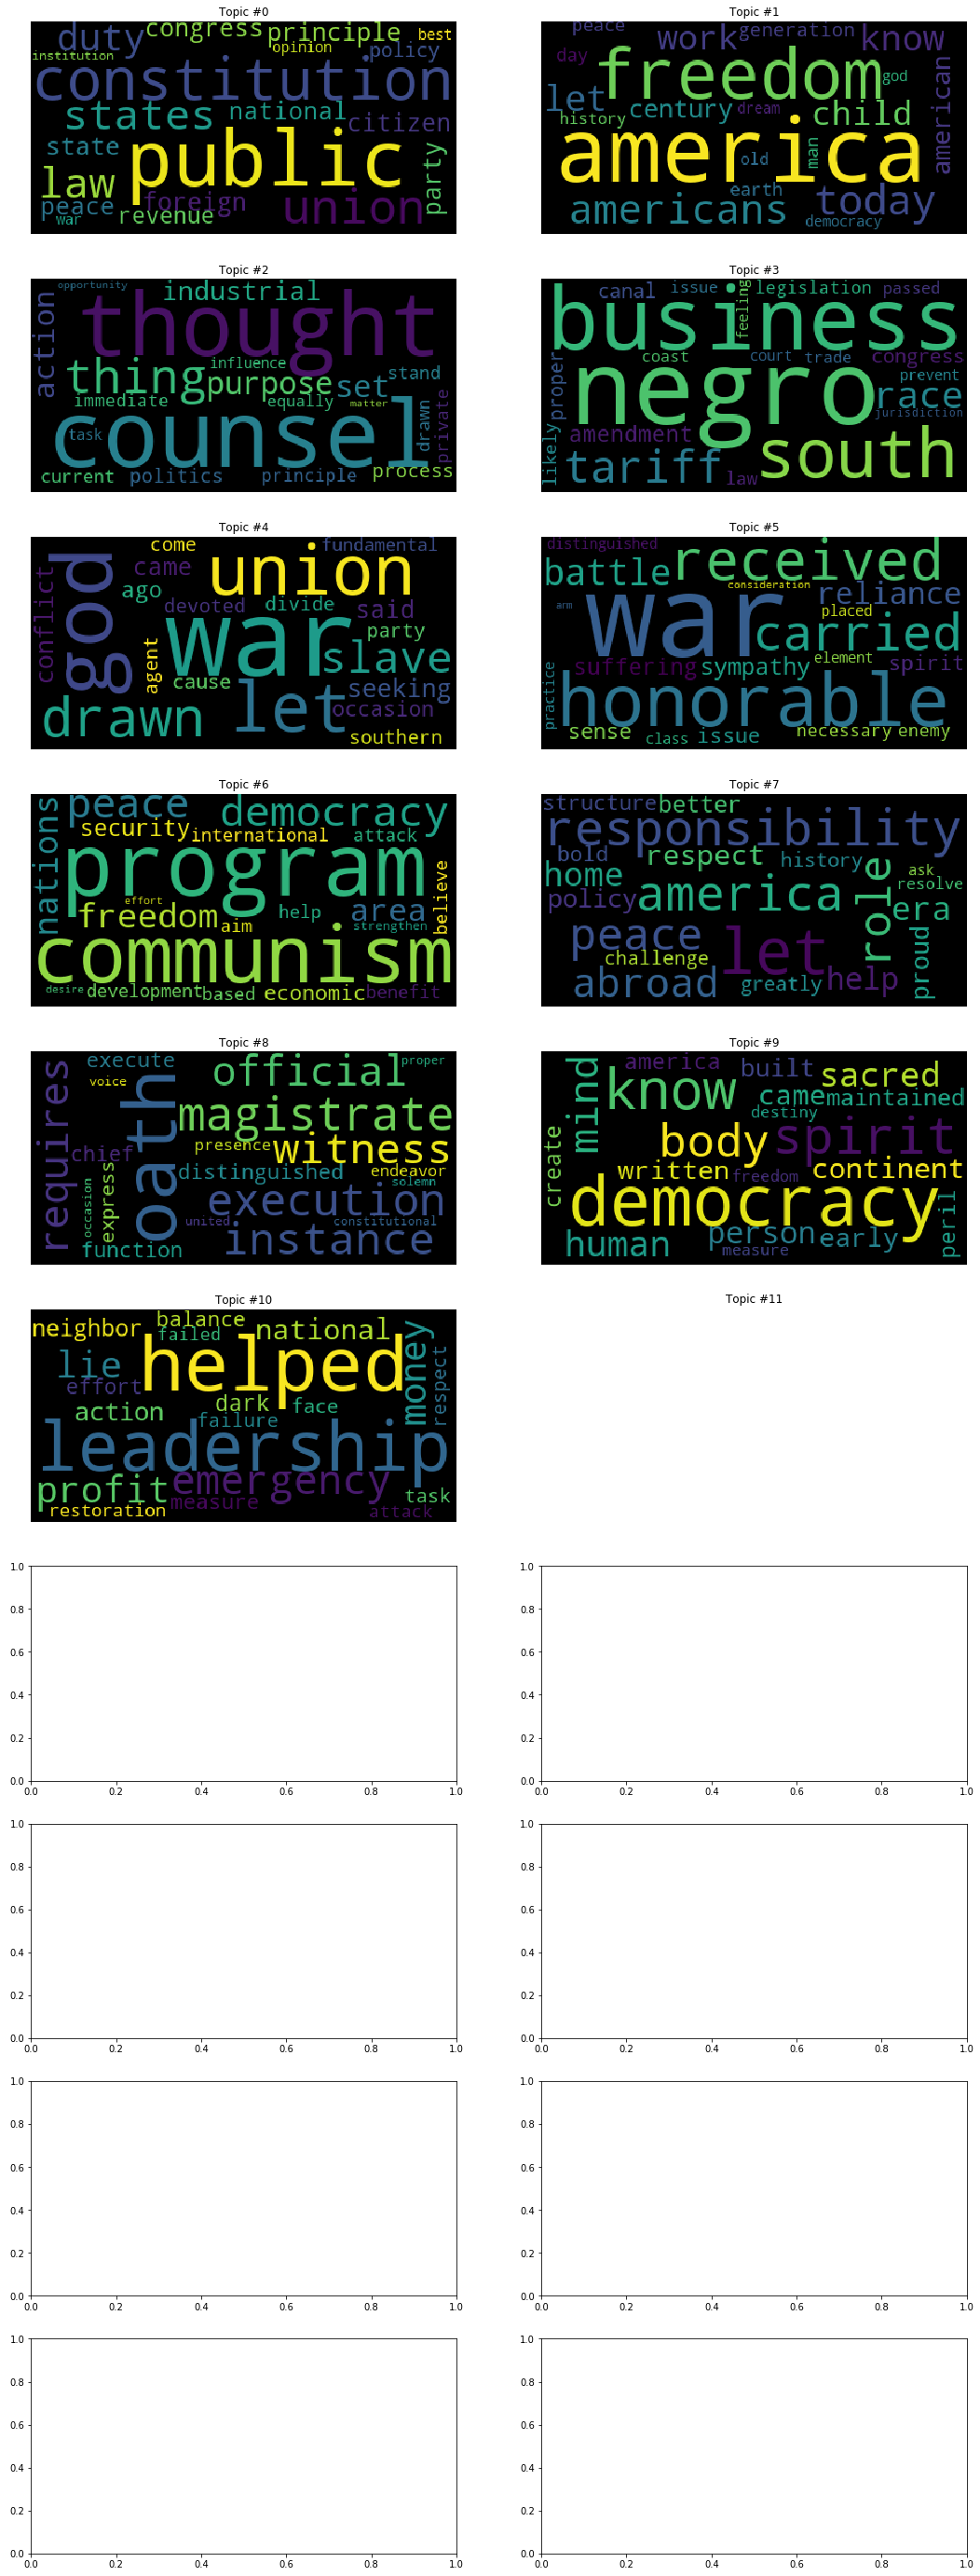

In [78]:
ncol = 2
nrow = int(np.ceil(len(component_dicts) / ncol))

figwidth = ncol * 9
figheight = nrow * 5
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(len(component_dicts)): 
    plt.sca(ax[t])    
    plt.title("Topic #" + str(t))
    plt.axis("off")    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))